***Alpha Backtester Examples***

In [1]:
import pytz
import yfinance
import requests
import threading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from bs4 import BeautifulSoup
from quantlab.utils import timeme
from quantlab.utils import save_pickle, load_pickle
from quantlab.utils import Portfolio

Here we just read in the ASX data to see what we're working with

In [2]:
asx200 = pd.read_csv("ASX_Listed_Companies_16-06-2024_09-02-02_AEST.csv")
asx200.head()

,ASX code,Company name,GICs industry group,Listing date,Market Cap
0,14D,1414 DEGREES LIMITED,Capital Goods,12/09/2018,16195459
1,1AD,ADALTA LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",22/08/2016,14890588
2,1AE,AURORA ENERGY METALS LIMITED,Materials,18/05/2022,11818207
3,1AG,ALTERRA LIMITED,"Food, Beverage & Tobacco",16/05/2008,4310732
4,1AI,ALGORAE PHARMACEUTICALS LIMITED,"Pharmaceuticals, Biotechnology & Life Sciences",01/09/2004,18561342


Next we want to isolate the tickers and filter each stock for a market cap above A$1bn. Then we append the .AX symbol to each ticker so that they can be correctly parsed to the yahoo finance API 

In [3]:
asx200['Market Cap'] = asx200['Market Cap'].str.replace(',', '').apply(pd.to_numeric, errors='coerce')
asx200 = asx200[asx200['Market Cap'].notna()]
asx200['Market Cap'] = asx200['Market Cap'].astype(int)
asx200_tickers = asx200.loc[asx200['Market Cap'] >= 1000000000,"ASX code"].to_list()
asx200_tickers = [ticker + '.AX' for ticker in asx200_tickers]
asx200_tickers

['360.AX',
 'A2M.AX',
 'ABB.AX',
 'ABC.AX',
 'ABG.AX',
 'AD8.AX',
 'ADT.AX',
 'AFI.AX',
 'AGL.AX',
 'AIA.AX',
 'AIZ.AX',
 'ALD.AX',
 'ALL.AX',
 'ALQ.AX',
 'ALU.AX',
 'ALX.AX',
 'AMC.AX',
 'AMP.AX',
 'ANN.AX',
 'ANZ.AX',
 'APA.AX',
 'APE.AX',
 'APM.AX',
 'ARB.AX',
 'ARF.AX',
 'ARG.AX',
 'ASK.AX',
 'ASX.AX',
 'ATM.AX',
 'AUB.AX',
 'AUI.AX',
 'AWC.AX',
 'AX1.AX',
 'AZJ.AX',
 'BAP.AX',
 'BEN.AX',
 'BFL.AX',
 'BGA.AX',
 'BGL.AX',
 'BHP.AX',
 'BKI.AX',
 'BKW.AX',
 'BOE.AX',
 'BOQ.AX',
 'BPT.AX',
 'BRG.AX',
 'BSL.AX',
 'BWP.AX',
 'BXB.AX',
 'CAR.AX',
 'CBA.AX',
 'CDA.AX',
 'CEN.AX',
 'CGF.AX',
 'CHC.AX',
 'CIA.AX',
 'CIP.AX',
 'CKF.AX',
 'CLW.AX',
 'CMM.AX',
 'CMW.AX',
 'CNI.AX',
 'CNU.AX',
 'COH.AX',
 'COL.AX',
 'CPU.AX',
 'CQR.AX',
 'CRN.AX',
 'CSC.AX',
 'CSL.AX',
 'CSR.AX',
 'CTD.AX',
 'CU6.AX',
 'CWY.AX',
 'DBI.AX',
 'DDR.AX',
 'DEG.AX',
 'DHG.AX',
 'DMP.AX',
 'DOW.AX',
 'DRO.AX',
 'DRR.AX',
 'DTL.AX',
 'DUI.AX',
 'DXS.AX',
 'DYL.AX',
 'EBO.AX',
 'EDV.AX',
 'ELD.AX',
 'EMR.AX',
 'EVN.AX',

Below are our main functions used to scrape and format our OHLCV data for both the S&P and ASX200. The get_histories() function utilise multithreading capabilities to speed up the webscraping/data download process

In [4]:
def get_sp500_tickers():
    res = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    soup = BeautifulSoup(res.content,'html')
    table = soup.find_all('table')[0] 
    df = pd.read_html(str(table))
    tickers = list(df[0].Symbol)
    return tickers

def get_history(ticker, period_start, period_end, granularity="1d", tries=0):
    try:
        df = yfinance.Ticker(ticker).history(
            start=period_start,
            end=period_end,
            interval=granularity,
            auto_adjust=True
        ).reset_index()
    except Exception as err:
        if tries < 5:
            return get_history(ticker, period_start, period_end, granularity, tries+1)
        return pd.DataFrame()
    
    df = df.rename(columns={
        "Date":"datetime",
        "Open":"open",
        "High":"high",
        "Low":"low",
        "Close":"close",
        "Volume":"volume"
    })
    if df.empty:
        return pd.DataFrame()
    df.datetime = pd.DatetimeIndex(df.datetime.dt.date).tz_localize(pytz.utc)
    df = df.drop(columns=["Dividends", "Stock Splits"])
    df = df.set_index("datetime",drop=True)
    return df

def get_histories(tickers, period_starts,period_ends, granularity="1d"):
    dfs = [None]*len(tickers)
    def _helper(i):
        print(tickers[i])
        df = get_history(
            tickers[i],
            period_starts[i], 
            period_ends[i], 
            granularity=granularity
        )
        dfs[i] = df
    threads = [threading.Thread(target=_helper,args=(i,)) for i in range(len(tickers))]
    [thread.start() for thread in threads]
    [thread.join() for thread in threads]
    tickers = [tickers[i] for i in range(len(tickers)) if not dfs[i].empty]
    dfs = [df for df in dfs if not df.empty]
    return tickers, dfs

def get_ticker_dfs(index,start,end):
    from quantlab.utils import load_pickle,save_pickle
    if index == "S&P":
        try:
            tickers, ticker_dfs = load_pickle("S&P.dataset.obj")
        except Exception as err:
            tickers = get_sp500_tickers()
            starts=[start]*len(tickers)
            ends=[end]*len(tickers)
            tickers,dfs = get_histories(tickers,starts,ends,granularity="1d")
            ticker_dfs = {ticker:df for ticker,df in zip(tickers,dfs)}
            save_pickle("S&P.dataset.obj", (tickers,ticker_dfs))
    elif index == "ASX":
        try:
            tickers, ticker_dfs = load_pickle("ASX.dataset.obj")
        except Exception as err:
            asx200 = pd.read_csv("ASX_Listed_Companies_16-06-2024_09-02-02_AEST.csv")
            asx200['Market Cap'] = asx200['Market Cap'].str.replace(',', '').apply(pd.to_numeric, errors='coerce')
            asx200 = asx200[asx200['Market Cap'].notna()]
            asx200['Market Cap'] = asx200['Market Cap'].astype(int)
            asx200_tickers = asx200.loc[asx200['Market Cap'] >= 1000000000,"ASX code"].to_list()
            asx200_tickers = [ticker + '.AX' for ticker in asx200_tickers]
            tickers = asx200_tickers
            starts=[start]*len(tickers)
            ends=[end]*len(tickers)
            tickers,dfs = get_histories(tickers,starts,ends,granularity="1d")
            ticker_dfs = {ticker:df for ticker,df in zip(tickers,dfs)}
            save_pickle("ASX.dataset.obj", (tickers,ticker_dfs))
    return tickers, ticker_dfs 

Then getting our data is as simple as defining our start and end periods and our index like below. Additonally the functions save the full set of tickers and their respective OHLCV data in compressed pickle files: ASX.dataset.obj  and S&P.dataset.obj, so that the next time the funcitons are called, they check to see if the dataset has already been created in turn saving time rather than trying to scrape/download the data gain

In [5]:
period_start = datetime(2000,1,1, tzinfo=pytz.utc)
period_end = datetime(2024,1,1, tzinfo=pytz.utc)
    
asx_tickers, asx_ticker_dfs = get_ticker_dfs(index="ASX",start=period_start,end=period_end)

We can check that the data is producing what we want:

In [6]:
asx_ticker_dfs['BHP.AX']

,open,high,low,close,volume
datetime,,,,,
2000-01-03 00:00:00+00:00,2.492540,2.492540,2.492540,2.492540,0
2000-01-04 00:00:00+00:00,2.492416,2.583389,2.492416,2.579650,10697907
2000-01-05 00:00:00+00:00,2.518585,2.536032,2.487430,2.519582,9801582
2000-01-06 00:00:00+00:00,2.524817,2.567187,2.524817,2.536032,8170358
2000-01-07 00:00:00+00:00,2.543386,2.679347,2.542264,2.661277,17781091
...,...,...,...,...,...
2023-12-21 00:00:00+00:00,48.169231,48.637366,47.857140,48.510582,8985068
2023-12-22 00:00:00+00:00,48.686130,48.764155,48.481322,48.500828,10576800
2023-12-27 00:00:00+00:00,48.764155,49.349323,48.666628,49.017727,5435683


We do the same for the S&P500:

In [7]:
snp_tickers, snp_ticker_dfs = get_ticker_dfs(index="S&P",start=period_start,end=period_end)

In [8]:
snp_ticker_dfs['AAPL']

,open,high,low,close,volume
datetime,,,,,
2000-01-03 00:00:00+00:00,0.792742,0.850379,0.768648,0.846127,535796800
2000-01-04 00:00:00+00:00,0.818253,0.836206,0.764869,0.774790,512377600
2000-01-05 00:00:00+00:00,0.784238,0.835734,0.778569,0.786128,778321600
2000-01-06 00:00:00+00:00,0.802191,0.808805,0.718097,0.718097,767972800
2000-01-07 00:00:00+00:00,0.729436,0.763452,0.721878,0.752113,460734400
...,...,...,...,...,...
2023-12-22 00:00:00+00:00,194.931260,195.160978,192.724085,193.353287,37122800
2023-12-26 00:00:00+00:00,193.363270,193.642911,192.584265,192.803986,28919300
2023-12-27 00:00:00+00:00,192.244692,193.253399,190.846467,192.903839,48087700


Below we outline a few examples of how to use the alpha backtest library 

We note that for risk management purposes, the backtesting library has a target portfolio/strategy volatility. This is the volatility in dollar terms rescaled to daily granularity for the entire portfolio. The end result is that the backtester automatically scales positions inversely proportional to each instruments vol, resulting in an overall strategy/portfolio which achieves your target vol which in our case is set to 20%

**Example 1**

Mag7 Momentum

Lets say we want to test a momentum strategy for the Mag7 tech stocks from 2000 to 2024. Our strategy involves a moving crossover of the daily closing price where our alpha is compromised of three indicators, where each one is worth 1 point meaning the max alpha/long signal = 3 (+1 for each crossover indicator). Our strategy will then aim to go long in size the higher the alpha score for each stock in our portfolio, it will adjust its weights daily based off these alpha scores

We import the Alpha class from our library and define our universe of stocks

In [9]:
from quantlab.utils import Alpha

mag7 = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'TSLA', 'META']
mag7

['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'TSLA', 'META']

Below we define our theoretical strategy as Alpha1 and pre-compute our momentum indicators to claulcate the alpha weighting. Alpha1 inherits from Alpha menaing it abstracts away all of the underlying computations and allows you to focus on implementing the indicators

In [10]:
class Alpha1(Alpha):
    def __init__(self,insts,dfs,start,end):
        super().__init__(insts,dfs,start,end)
    
    def pre_compute(self,trade_range):
        for inst in self.insts:
            inst_df = self.dfs[inst]
            fast = np.where(inst_df.close.rolling(10).mean() > inst_df.close.rolling(50).mean(), 1, 0)
            medium = np.where(inst_df.close.rolling(20).mean() > inst_df.close.rolling(100).mean(), 1, 0)
            slow = np.where(inst_df.close.rolling(50).mean() > inst_df.close.rolling(200).mean(), 1, 0)
            alpha = fast + medium + slow
            self.dfs[inst]["alpha"] = alpha
        return
    
    def post_compute(self,trade_range):
        temp = []
        for inst in self.insts:
            temp.append(self.dfs[inst]["alpha"])
        alphadf = pd.concat(temp,axis=1)
        alphadf.columns = self.insts
        alphadf = alphadf.fillna(method="ffill")
        self.eligblesdf = self.eligiblesdf & (~pd.isna(alphadf))
        self.alphadf = alphadf
        return

    def compute_signal_distribution(self, eligibles, date):
        return self.alphadf.loc[date]

Implementing the strategy is as simple as calling Alpha1 and inputting: insts= 'Our list of stocks', dfs= 'Our univers of OHLCV data' and then our start/end periods

In [11]:
alpha1 = Alpha1(insts=mag7,dfs=snp_ticker_dfs,start=period_start,end=period_end)

Then we call the run_simulation() method to run the backtest

In [12]:
df1=alpha1.run_simulation()

/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:238: RuntimeWarning: invalid value encountered in divide
  forecasts = forecasts/eligibles_row
/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:251: RuntimeWarning: invalid value encountered in divide
  weights = positions * close_row / nominal_tot
/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:238: RuntimeWarning: divide by zero encountered in divide
  forecasts = forecasts/eligibles_row


@timeme: run_simulation took 1.0564351081848145 seconds


We can see the system is extrmeley sat, completing the backtest for 24 year of data in 1 second

The end result is a dataframe that contains: the notional amounts of each stock, their respective potfolio weights, the amount of leverage used, our nominal totl of capital, nominal return on capital, as well as the capital return including leverage and our ending capital

In [13]:
df1.tail()

,AAPL units,MSFT units,GOOG units,AMZN units,NVDA units,TSLA units,META units,AAPL w,MSFT w,GOOG w,AMZN w,NVDA w,TSLA w,META w,leverages,strat_scalar,nominal_tot,nominal_ret,capital_ret,capital
2023-12-28 00:00:00+00:00,5675.732341,1517.168118,3809.320828,2976.355530,7275.496508,794.678565,1466.185458,0.293052,0.151503,0.143566,0.121919,0.096210,0.053733,0.140018,1.608388,1.312000,3.744413e+06,-0.000843,-0.001182,2.328053e+06
2023-12-29 00:00:00+00:00,5891.412933,2794.951401,4082.189543,3106.381551,7510.003726,969.535820,1383.527585,0.261736,0.241949,0.132771,0.109050,0.085918,0.055662,0.112915,1.875663,1.366524,4.328127e+06,-0.005484,-0.008821,2.307518e+06
2023-12-30 00:00:00+00:00,6015.831526,2853.976956,4168.399809,3171.984086,7668.604745,990.011092,1412.745798,0.261736,0.241949,0.132771,0.109050,0.085918,0.055662,0.112915,1.915275,1.395383,4.419531e+06,0.000000,0.000000,2.307518e+06
2023-12-31 00:00:00+00:00,6015.831526,2853.976956,4168.399809,3171.984086,7668.604745,990.011092,1412.745798,0.261736,0.241949,0.132771,0.109050,0.085918,0.055662,0.112915,1.915275,1.395383,4.419531e+06,0.000000,0.000000,2.307518e+06
2024-01-01 00:00:00+00:00,6015.831526,2853.976956,4168.399809,3171.984086,7668.604745,990.011092,1412.745798,0.261736,0.241949,0.132771,0.109050,0.085918,0.055662,0.112915,1.915275,1.395383,4.419531e+06,0.000000,0.000000,2.307518e+06


We can also retrieve backtest statistics by calling the get_perf_stats() method. If we set plot=True then the method will create some plots and save them to file

In [14]:
stats = alpha1.get_perf_stats(plot=True)


The get_perf_stats() method returns a dictionary of various statistics, we can see what statistics are calculated by checking the keys:

In [15]:
stats.keys()

dict_keys(['cum_ret', 'log_ret', 'max_dd', 'cagr', 'srtno', 'sharpe', 'mean_ret', 'median_ret', 'vol', 'var', 'skew', 'exkurt', 'rcagr', 'calmar', 'var95', 'cvar'])

Below we display the plots for the rolling maximum drawdowns to see where the strategy has performed poorly, a kernel density estimate of returns to get an understanding of the strategies return distribution, as well as an equity curve to see how the strategy performed over time in general

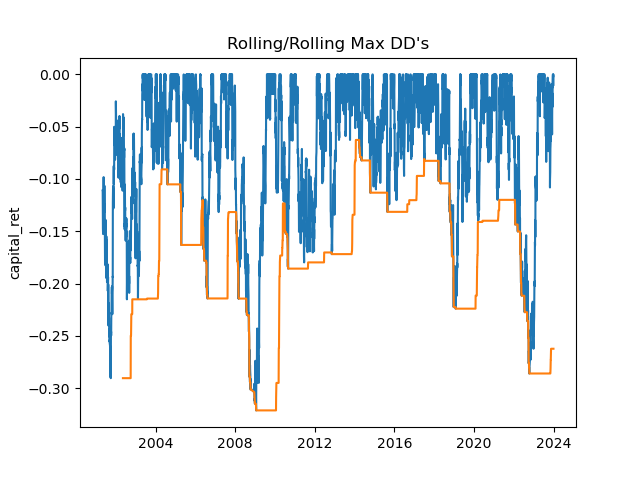

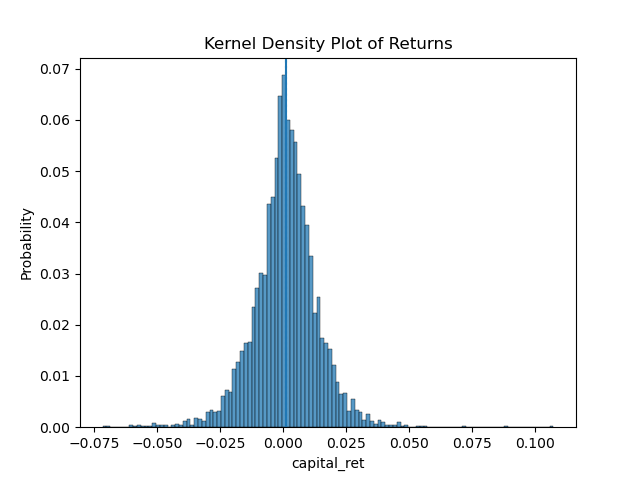

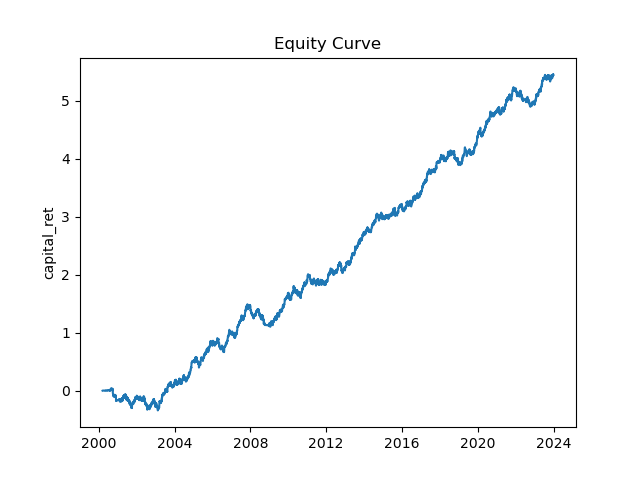

In [16]:
from IPython.display import Image, display
x = Image(filename='images/drawdowns.png') 
y = Image(filename='images/kde.png')
z = Image(filename='images/log_ret.png') 
display(x, y, z)


Getting the strategies sharpe ratio is as easy as indexing stats by 'sharpe'

In [17]:
stats['sharpe']

1.263518493762992

Getting the total return is as simple as finding the final log_ret figure and multiplying by 100, we can see this strategy 5x'ed our money

In [18]:
stats['log_ret'][-1] 

5.44134268667701

And we can check our strategy has adhered to the 20% vol target:

In [19]:
stats['vol'] * 100

20.21222818554028

Now we show how the 'no code version can be implemented. To do this we import the Gene and GeneticAlpha classes from our backtest library. Now instead of having to manually code the alpha indicators, we can pass a string which outlines our strategy/alpha rules as such:

"plus(ite(gt(mean_10(close),mean_50(close)),const_1,const_0),ite(gt(mean_20(close),mean_100(close)),const_1,const_0),ite(gt(mean_50(close),mean_200(close)),const_1,const_0))"

 - Plus: adds everything in the brackets, this works by adding each alpha indicator returning 0,1,2,3
 - ite: Stands for "if then else" this allows us to work conditional rules into our rules. 
 - gt: stands for "greater than" to allow us to compare two numbers
 - mean_10: calulates the rolling 10 day mean, any number can be set after the _ to find the rolling window
 - const_1, const_0: sets the value to 1 or 0, for example 'ite(gt(mean_10(close),mean_50(close)),const_1,const_0)' means the alpha is set to 1 when the rolling 10 day mean of the close is greater than the rolling 50 day mean the alpha is set to 1 and 0 other wise


the end reuslt is we are able to backtest our same strategy without writing any explicit code, example below:

*No Code Version*

In [20]:
from quantlab.gene import GeneticAlpha
from quantlab.gene import Gene

g1=Gene.str_to_gene("plus(ite(gt(mean_10(close),mean_50(close)),const_1,const_0),ite(gt(mean_20(close),mean_100(close)),const_1,const_0),ite(gt(mean_50(close),mean_200(close)),const_1,const_0))")

nc_alpha1 = GeneticAlpha(insts=mag7,dfs=snp_ticker_dfs,start=period_start,end=period_end, genome=g1)
nc_df1 = nc_alpha1.run_simulation()
nc_stats = nc_alpha1.get_perf_stats(plot=True)



/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:238: RuntimeWarning: invalid value encountered in divide
  forecasts = forecasts/eligibles_row
/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:251: RuntimeWarning: invalid value encountered in divide
  weights = positions * close_row / nominal_tot
/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:238: RuntimeWarning: divide by zero encountered in divide
  forecasts = forecasts/eligibles_row


@timeme: run_simulation took 3.1623308658599854 seconds


We can see that the reuslts are the same for the code and no code versions

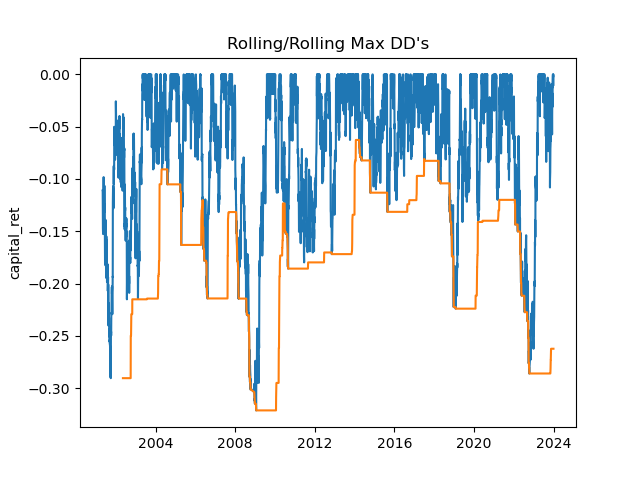

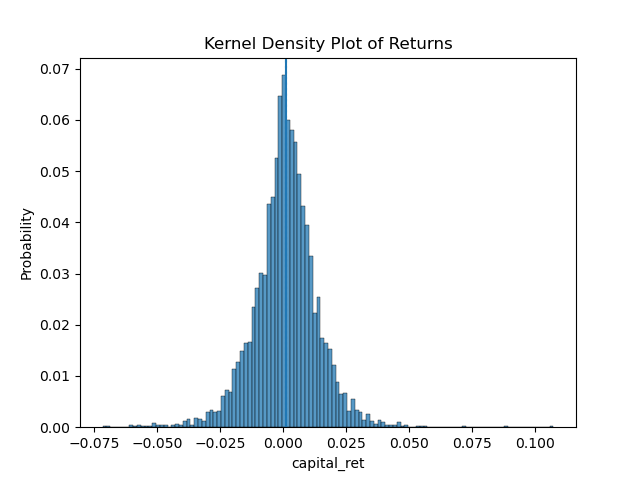

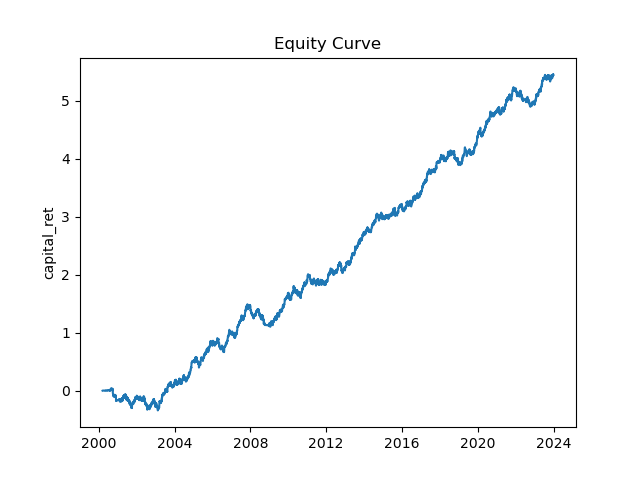

In [21]:
from IPython.display import Image, display
x = Image(filename='images/drawdowns.png') 
y = Image(filename='images/kde.png')
z = Image(filename='images/log_ret.png') 
display(x, y, z)


Same with our calculated statistics

In [22]:
nc_stats['sharpe']


1.263518493762992

In [23]:
nc_stats['log_ret'][-1] 

5.44134268667701

The next example shows how we can get as abritrarily complicated as we want with our alpha research



**Example 2**

Volume-Weighted RSI L/S basket of Aussie banks

Below we define our new univers of stocks to test

In [24]:
banks = ['CBA.AX', 'NAB.AX', 'WBC.AX', 'ANZ.AX', 'MQG.AX', 'BEN.AX', 'AMP.AX', 'BOQ.AX']



Say we want to create a L/S basket of AU banks based off a volume weighted momentum indicator that measures buying and selling pressure via OHLCV data:

The indicator is known as the Money Flow Index (MFI) or sometimes called the Volume-Weighted RSI. It is a momentum oscillator that incorporates both price and volume data to measure buying and selling pressure.
Here's how the calculation works:

- op1 = volume: This is simply the trading volume for the given period.
- op2 = (close - low) - (high - close): This is the Money Flow (MF). It measures the buying and selling pressure by comparing the close to the high and low of the period. If the close is closer to the high, the MF is positive, indicating buying pressure. If the close is closer to the low, the MF is negative, indicating selling pressure.
- op3 = high - low: This is the range of the price for the period.
- op4 = op1 * op2 / op3: This is the Money Flow Volume (MFV). It is the Money Flow (op2) weighted by the volume (op1) and normalized by the price range (op3).

We then find the cross sectional z-score of this indicator. This will be our alpha signal, where we short the banks each day that have the indicator in the top 25 percentile (as a meaure of overbought names) and long the banks with the indicator in the bottom 75th percentile (under bought).


We define this as Alpha2

In [25]:
class Alpha2(Alpha):

    def __init__(self,insts,dfs,start,end):
        super().__init__(insts,dfs,start,end)
    
    def pre_compute(self,trade_range):
        self.op4s = {}
        for inst in self.insts:
            inst_df = self.dfs[inst]
            op1 = inst_df.volume
            op2 = (inst_df.close - inst_df.low) - (inst_df.high - inst_df.close)
            op3 = inst_df.high - inst_df.low
            op4 = op1 * op2 / op3       
            self.op4s[inst] = op4
        return 
    
    def post_compute(self,trade_range):
        temp = []
        for inst in self.insts:
            self.dfs[inst]["op4"] = self.op4s[inst]
            temp.append(self.dfs[inst]["op4"])

        temp_df = pd.concat(temp,axis=1)
        temp_df.columns = self.insts
        temp_df = temp_df.replace(np.inf, np.nan).replace(-np.inf, np.nan)
        zscore = lambda x: np.where(np.isnan(x), 0, (x - np.nanmean(x)) / np.nanstd(x)) if np.any(~np.isnan(x)) else x
        cszcre_df = temp_df.fillna(method="ffill").apply(zscore, axis=1, raw=True)
        
        alphas = []
        for inst in self.insts:
            self.dfs[inst]["alpha"] = cszcre_df[inst].rolling(10).mean() * -1
            alphas.append(self.dfs[inst]["alpha"])
        alphadf = pd.concat(alphas,axis=1)
        alphadf.columns = self.insts
        self.eligblesdf = self.eligiblesdf & (~pd.isna(alphadf))
        self.alphadf = alphadf
        masked_df = self.alphadf/self.eligblesdf
        masked_df = masked_df.replace([-np.inf, np.inf], np.nan)
        num_eligibles = self.eligblesdf.sum(axis=1)
        rankdf= masked_df.rank(axis=1,method="average",na_option="keep",ascending=True)
        shortdf = rankdf.apply(lambda col: col <= num_eligibles.values/4, axis=0,raw=True)
        longdf = rankdf.apply(lambda col: col > np.ceil(num_eligibles - num_eligibles/4), axis=0, raw=True)
       
        forecast_df = -1*shortdf.astype(np.int32) + longdf.astype(np.int32)
        self.forecast_df = forecast_df
        return 

    def compute_signal_distribution(self, eligibles, date):
        forecasts = self.forecast_df.loc[date].values
        return forecasts

Again all we need to do is input our stock univers into insts, our data universe to dfs, and then our start and end periods

In [26]:
alpha2 = Alpha2(insts=banks,dfs=asx_ticker_dfs,start=period_start,end=period_end)
df2=alpha2.run_simulation()


/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:238: RuntimeWarning: invalid value encountered in divide
  forecasts = forecasts/eligibles_row
/Users/edwardmckenzie/Desktop/Hanguk Lectures/QT301/quantlab/utils.py:251: RuntimeWarning: invalid value encountered in divide
  weights = positions * close_row / nominal_tot


@timeme: run_simulation took 1.5101962089538574 seconds


And we can check the end result of our portfolio weightings and returns

In [27]:
df2.tail()

,CBA.AX units,NAB.AX units,WBC.AX units,ANZ.AX units,MQG.AX units,BEN.AX units,AMP.AX units,BOQ.AX units,CBA.AX w,NAB.AX w,...,MQG.AX w,BEN.AX w,AMP.AX w,BOQ.AX w,leverages,strat_scalar,nominal_tot,nominal_ret,capital_ret,capital
2023-12-28 00:00:00+00:00,0.0,9271.540610,0.0,-11015.188052,0.0,0.0,-84261.870767,21982.780936,0.0,0.363628,...,0.0,0.0,-0.103365,0.169378,5.454392,3.154746,764542.485212,-0.003189,-0.014531,140170.071984
2023-12-29 00:00:00+00:00,0.0,9352.546799,0.0,-11126.277484,0.0,0.0,-76946.471791,22153.860592,0.0,0.367892,...,0.0,0.0,-0.092282,0.171935,5.324092,3.115484,761541.393316,0.003750,0.020452,143036.871084
2023-12-30 00:00:00+00:00,0.0,8848.938343,0.0,-10527.158597,0.0,0.0,-72803.119753,20960.937235,0.0,0.367892,...,0.0,0.0,-0.092282,0.171935,5.037404,2.947724,720534.521776,0.000000,0.000000,143036.871084
2023-12-31 00:00:00+00:00,0.0,8848.938343,0.0,-10527.158597,0.0,0.0,-72803.119753,20960.937235,0.0,0.367892,...,0.0,0.0,-0.092282,0.171935,5.037404,2.947724,720534.521776,0.000000,0.000000,143036.871084
2024-01-01 00:00:00+00:00,0.0,8848.938343,0.0,-10527.158597,0.0,0.0,-72803.119753,20960.937235,0.0,0.367892,...,0.0,0.0,-0.092282,0.171935,5.037404,2.947724,720534.521776,0.000000,0.000000,143036.871084


Retrieve our statistics

In [28]:
stats2 = alpha2.get_perf_stats(plot=True)

Below we can plot the performance of our L/S basket over the last 24 years

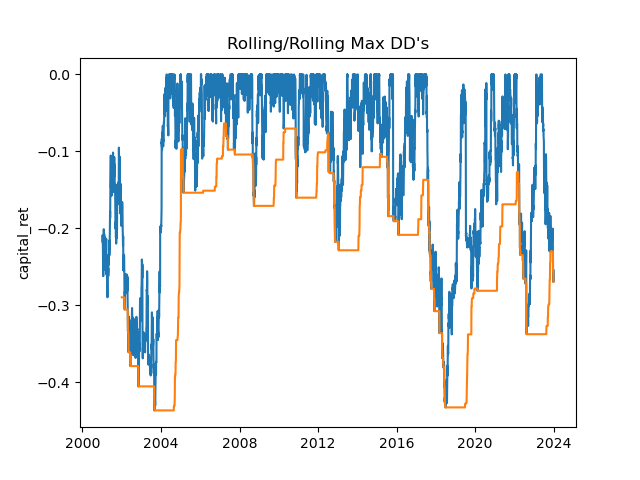

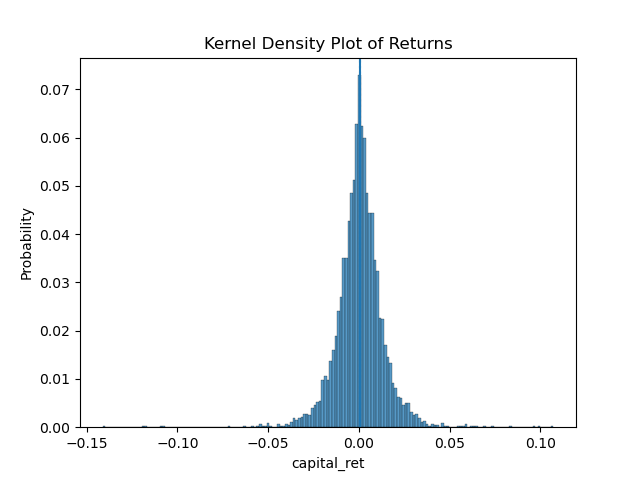

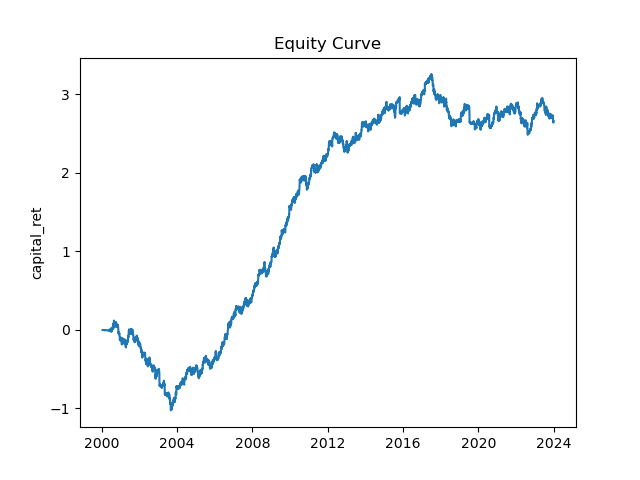

In [29]:
from IPython.display import Image, display
x = Image(filename='images/drawdowns.png') 
y = Image(filename='images/kde.png')
z = Image(filename='images/log_ret.png') 
display(x, y, z)


Additionally we can compute the sharpe ratio and total return as we did for the first strat

In [30]:
stats2['sharpe']

0.6342672404487212

In [31]:
stats2['log_ret'][-1]

2.6605173437758785

In [32]:
stats2['vol'] * 100

20.93784478694911

And again there is a no code alternative for the above strategy, lets say this time we only want to long the bottom 25th percentile rather than the rest of the basket. In no code form all we would do is change our L/S ratio to 25/25:

"ls_25/25(neg(mean_10(cszscre(div(mult(volume,minus(minus(close,low),minus(high,close))),minus(high,low))))))"

- ls: allows us to define our long short basket, where the numbers after are the percentile long / percentile short we want to go
- cszscore calcualtes the cross sectional z-score of the data points each day

A benefit of the L/S capability is that it allows us to create custom baskets and develop factor models as a result (coming soon)

In [35]:
g2=Gene.str_to_gene("ls_25/25(neg(mean_10(cszscre(div(mult(volume,minus(minus(close,low),minus(high,close))),minus(high,low))))))")

nc_alpha2 = GeneticAlpha(insts=banks,dfs=asx_ticker_dfs,start=period_start,end=period_end, genome=g2)
nc_df2 = nc_alpha2.run_simulation()
nc_stats2 = nc_alpha2.get_perf_stats(plot=True)

/Users/edwardmckenzie/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/edwardmckenzie/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/edwardmckenzie/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/edwardmckenzie/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/edwardmckenzie/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/edwardmckenzie/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return 

@timeme: run_simulation took 5.129681825637817 seconds


We can see that our results have improved significantly:

In [36]:
nc_stats2['sharpe']

0.9024113911326014

In [37]:
nc_stats2['log_ret'][-1]

3.913685633415052

In [38]:
nc_stats2['vol']

0.20331110064838617

This highlights how much easier it can be to test new ideas and changes with the system

And we can plot our new graphs

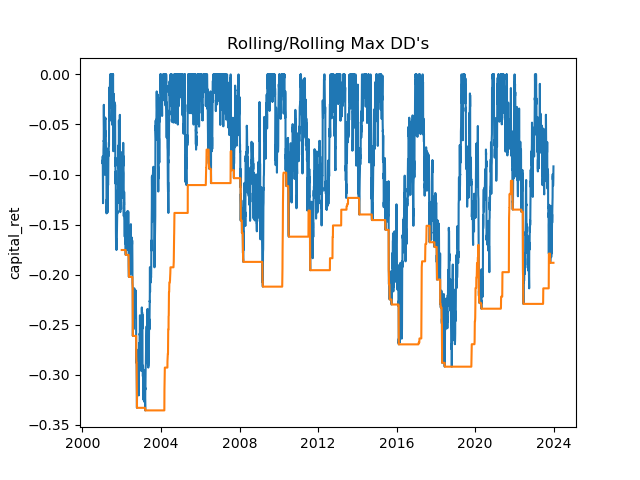

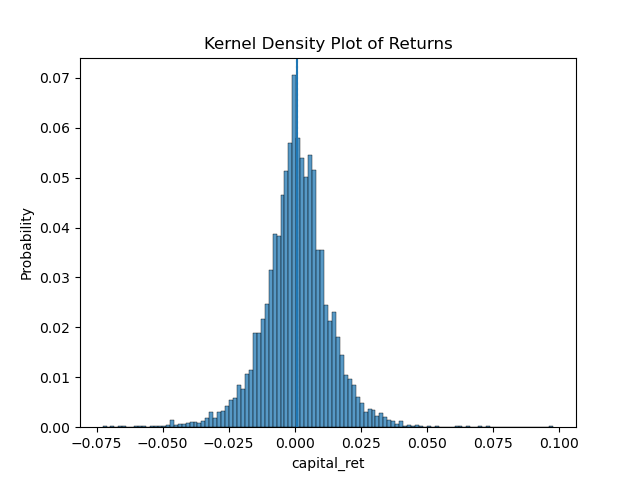

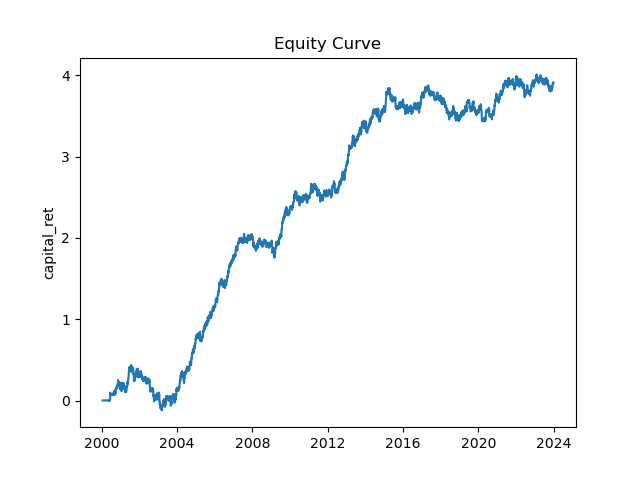

In [39]:
from IPython.display import Image, display
x = Image(filename='images/drawdowns.png') 
y = Image(filename='images/kde.png')
z = Image(filename='images/log_ret.png') 
display(x, y, z)

*Next Steps*

1. Include transaction costs and market impact models
2. Implement it so that is can accept J.P Morgan Data
3. Increase flexibility and ease of use
4. Implement factor modelling capabilties
5. Create a event based backtest system i.e allow for testing of certain names on certain dates across time
6. Allow for the combination and testing of different alphas in a portfolio